In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft
from scipy.optimize import line_search
from tensorflow.python import tf2
from keras.datasets import mnist
from scipy.linalg import convolution_matrix
from PIL import Image, ImageOps
import time
import colorsys

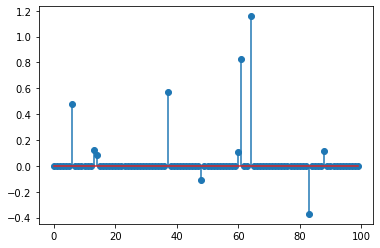

In [2]:
#Initializations
features = 200;
samples = 100;
A = np.random.randn(features,samples)
#Try different matrices
#y = np.random.randn(features)
#Initialize some random sparse solution
x0 = np.zeros((samples,1))
p = np.random.permutation(samples)
x0[p[:10]] = np.random.randn(10,1)
x0 = np.reshape(x0,-1)
y = A@x0
lam = .9 * np.max( np.abs(A.T @ y))
plt.stem(x0)
plt.show()

features_t = 50
A_test = np.random.randn(features_t,samples)
y_test = A_test@x0 

#Create array of regularization parameters
#lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/10, np.max(np.abs(A.T@y))/2, np.max(np.abs(A.T@y))])
lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/10])
lamsz = np.size(lamb)

In [29]:
#Create array of regularization parameters
#lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/10, np.max(np.abs(A.T@y))/2, np.max(np.abs(A.T@y))])
#lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/10])
lamb = np.array([np.max(np.abs(A.T@y))/50])
lamsz = np.size(lamb)
lamb

array([7.95148799])

In [14]:
def funcreg(A,x,y,lam):    #Return f(x)+g(x)
    dif = A@x - y
    if (lam == 0):
        return (1/2) * dif.T @ dif
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx
def SubdifTest(A,x,y,lam):          #Subdifferential Test to check for correct solution
    gradf = GradF(A,x,y)/lam
    return max(abs(gradf))
def GradF(A,x,y):                   #Calculate gradient of ||Ax-y||_2^2
    return (((A.T @ A) @ x) - A.T @ y)

In [6]:
def Hessianinv_uu(A,v,it):
    n = np.size(v)
    Dv = np.diag(v)
    Hyy = (np.eye(samples) + (1/lam)*(Dv @ ((A.T @ A) @ Dv)))
    Lg = np.linalg.norm(Hyy,2)
    Hyy = Hyy/Lg
    Hinv = np.eye(samples)
    HyyPow = np.eye(samples)-Hyy
    for i in range(it):
        Hinv = Hinv + HyyPow
        HyyPow = HyyPow @ (np.eye(samples) - Hyy)
    return (Hinv/(Lg))

In [7]:
def Hessianinv_uu_stc(A,v,b):
    m = np.size(A,0)
    n = np.size(A,1)
    p = np.random.randint(1,b-1)
    Dv = np.diag(v)
    Hyy = np.eye(n) + (1/lam)*(Dv @ ((A.T @ A) @ Dv))
    Lg = np.linalg.norm(Hyy,2)
    #Hlist = np.zeros((m,n,p))
    #for i in range(p):
    #    Ast = np.random.randn(features,samples)
    #    Hlist[:,:,i] = np.eye(samples) + (1/lam)*(Dv @ ((Ast.T @ Ast) @ Dv))
    
    Hinv = b*np.eye(n)/Lg
    if (p == 1):
        return Hinv
    
    
    for i in range(p):
        #Ast = np.random.randn(m,n)
        #Ast = np.random.randn(n)
        randint = np.random.randint(0, m)
        Ast = A[randint,:]
        #Hst = np.eye(n) + (1/lam)*(Dv @ ((Ast.T @ Ast) @ Dv))
        Hst = np.eye(n) + (1/lam)*(Dv @ ((np.outer(Ast,Ast)) @ Dv))
        Hinv = Hinv @ (np.eye(n) - (1/Lg)*Hst)
            
    return Hinv

In [20]:
iters = 100
b = 50
u = np.random.rand(samples)
v = np.random.rand(samples)
Hinv = np.linalg.inv(np.eye(samples) + (1/lam)*(np.diag(v) @ ((A.T @ A) @ np.diag(v))))
Hinv_calc = Hessianinv_uu(A,v,iters)
Hinv_calc_st = Hessianinv_uu_stc(A,v,b)
err = np.linalg.norm(Hinv-Hinv_calc,2)
rel_err = err / np.linalg.norm(Hinv_calc,2)
err_st = np.linalg.norm(Hinv-Hinv_calc_st,2)
rel_err_st = err_st / np.linalg.norm(Hinv_calc_st,2)
print('Comparing normal inverse calculation and formula:')
print('Error is ', err)
print('Relative error is ', rel_err)
print('Comparing normal inverse calculation and stochastic:')
print('Error is ', err_st)
print('Relative error is ', rel_err_st)

Comparing normal inverse calculation and formula:
Error is  3.0205667618429056e-15
Relative error is  3.0205667618429036e-15
Comparing normal inverse calculation and stochastic:
Error is  0.9999952994197557
Relative error is  212738.6933317762


# Bi-level formulation

In [38]:
#Helper functions for calculating various derivatives
def gnabU(u,v,X,y,lam):
    if (np.size(X) == np.size(v)):
        #return u + (1/lam)*v*(np.outer(X,X)@(v*u) - X * y)
        return lam*u + v*(np.outer(X,X)@(v*u) - X * y)
    
    #return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)
    return lam*u + v*((X.T @ X)@(v*u) - X.T @ y)
def fnabV(u,v,X,y,lam):
    if (np.size(X) == np.size(v)):
        #return v + (1/lam)*u*(np.outer(X,X)@(v*u) - X.T * y)
        return lam*v + u*(np.outer(X,X)@(v*u) - X.T * y)
    
    #return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)
    return lam*v + u*((X.T @ X)@(v*u) - X.T @ y)
def fnabU(u,v,X,y,lam):
    if (np.size(X) == np.size(v)):
        #return (1/lam)*v*(np.outer(X,X)@(v*u) - X.T * y)
        return v*(np.outer(X,X)@(v*u) - X.T * y)
    
    #return (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)
    return v*((X.T @ X)@(v*u) - X.T @ y)
def gnabVU(u,v,A,y,lam):
    if (np.size(A) == np.size(v)):
        D1 = np.diag(np.outer(A,A) @ (np.diag(u) @ v))
        D2 = (np.diag(u) @ (np.outer(A,A) @ np.diag(v)))
        D3 = np.diag(A.T * y)
        #return (1/lam)*(D1 + D2 - D3)
        return (D1 + D2 - D3)
    ATA = A.T @ A
    D1 = np.diag(ATA @ (np.diag(u) @ v))
    D2 = np.diag(u) @ ATA @ np.diag(v)
    D3 = np.diag(A.T @ y)
    #return (1/lam)*(D1 + D2 - D3)
    return (D1 + D2 - D3)
def gnabUU(v,A,y,lam):
    n = np.size(v)
    if (np.size(A) == n):
        #return np.eye(n) + (1/lam)*(np.diag(v) @ (np.outer(A,A) @ np.diag(v)))
        return lam*np.eye(n) + (np.diag(v) @ (np.outer(A,A) @ np.diag(v)))
    return np.eye(n) + (1/lam)*((np.diag(v) @ A.T) @ (A @ np.diag(v)))
def Muv(u,v,A,y,lam):
    return gnabVU(u,v,A,y,lam) @ np.linalg.inv(gnabUU(v,A,y,lam))
def NablaF(u,v,A,y,lam):
    return fnabV(u,v,A,y,lam) - Muv(u,v,A,y,lam) @ fnabU(u,v,A,y,lam)

iteration 0
|Nabla g(u*,v)|_2 = 0.0
iteration 1
|Nabla g(u*,v)|_2 = 0.0
iteration 2
|Nabla g(u*,v)|_2 = 0.0
iteration 3
|Nabla g(u*,v)|_2 = 0.0005629561967867801
iteration 4
|Nabla g(u*,v)|_2 = 0.019090549026993565
iteration 5
|Nabla g(u*,v)|_2 = 0.0072676510466576005
iteration 6
|Nabla g(u*,v)|_2 = 0.007195449561863625
iteration 7
|Nabla g(u*,v)|_2 = 0.007069260550291921
iteration 8
|Nabla g(u*,v)|_2 = 0.006622173604166145
iteration 9
|Nabla g(u*,v)|_2 = 0.006345970885958154
iteration 10
|Nabla g(u*,v)|_2 = 0.006122525390178638
iteration 11
|Nabla g(u*,v)|_2 = 0.005924596292318636
iteration 12
|Nabla g(u*,v)|_2 = 0.005746233052522965
iteration 13
|Nabla g(u*,v)|_2 = 0.00558800500685534
iteration 14
|Nabla g(u*,v)|_2 = 0.005452914707835932
iteration 15
|Nabla g(u*,v)|_2 = 0.005342398594635956
iteration 16
|Nabla g(u*,v)|_2 = 0.005248894929651589
iteration 17
|Nabla g(u*,v)|_2 = 0.005147943771184513
iteration 18
|Nabla g(u*,v)|_2 = 0.005004796423892711
iteration 19
|Nabla g(u*,v)|_2 = 0

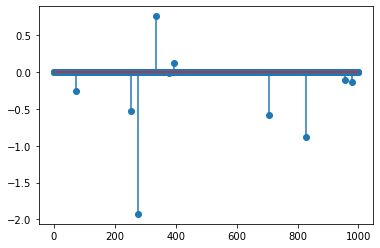

iteration 0
|Nabla g(u*,v)|_2 = 0.0
iteration 1
|Nabla g(u*,v)|_2 = 0.0
iteration 2
|Nabla g(u*,v)|_2 = 0.0
iteration 3
|Nabla g(u*,v)|_2 = 0.0
iteration 4
|Nabla g(u*,v)|_2 = 0.0
iteration 5
|Nabla g(u*,v)|_2 = 0.0
iteration 6
|Nabla g(u*,v)|_2 = 0.0
iteration 7
|Nabla g(u*,v)|_2 = 0.0
iteration 8
|Nabla g(u*,v)|_2 = 0.0
iteration 9
|Nabla g(u*,v)|_2 = 0.0
iteration 10
|Nabla g(u*,v)|_2 = 0.0
iteration 11
|Nabla g(u*,v)|_2 = 0.0
iteration 12
|Nabla g(u*,v)|_2 = 0.0
iteration 13
|Nabla g(u*,v)|_2 = 0.0
iteration 14
|Nabla g(u*,v)|_2 = 0.0
iteration 15
|Nabla g(u*,v)|_2 = 0.0
iteration 16
|Nabla g(u*,v)|_2 = 1.6543612251060553e-24
iteration 17
|Nabla g(u*,v)|_2 = 3.772955286949268e-19
iteration 18
|Nabla g(u*,v)|_2 = 1.4656636438619406e-14
iteration 19
|Nabla g(u*,v)|_2 = 2.7990770380791505e-13
iteration 20
|Nabla g(u*,v)|_2 = 1.8934722256923563e-12
iteration 21
|Nabla g(u*,v)|_2 = 5.803306493765297e-12
iteration 22
|Nabla g(u*,v)|_2 = 7.76982113890457e-12
iteration 23
|Nabla g(u*,v)|_2

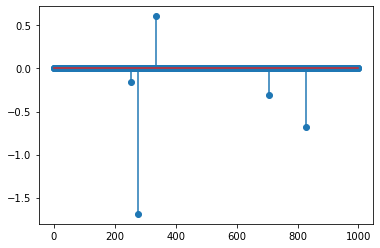

Text(0.5, 1.0, 'Solution')

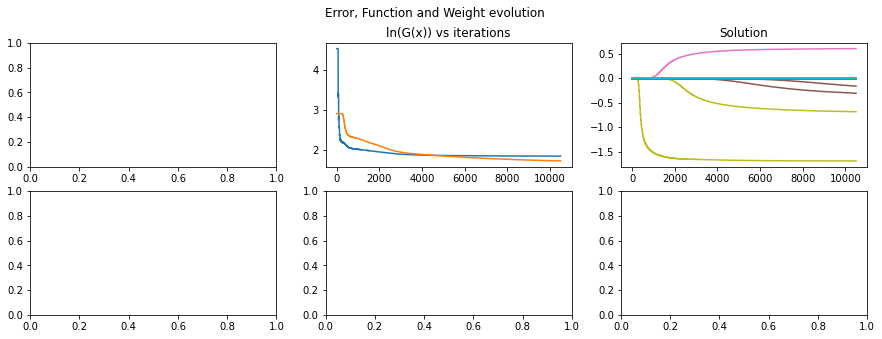

In [13]:
#Standard BA method
niter = 500
niteru = 20
xtemp3 = np.zeros((samples,niter))
#epoch_sz = 2*features
funcvec_svr = np.zeros((lamsz,(niteru+1)*niter))
#steparr = np.zeros((2,niter))
xtemp3 = np.zeros((samples,(niteru+1)*niter))
#time_svr = np.zeros((lamsz,niter*epoch_sz))
mug = 1
#start = time.time()
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    #u = np.zeros(samples)
    #v = np.zeros(samples)
    #stepu = 0.001
    #stepv = 0.0001
    #start = time.time()
    for it in range(niter):
        print('iteration',it)
        #funcvec_temp = np.zeros(niteru+1)
        #xtemptemp = np.zeros((samples,niteru+1))
        Lg = np.linalg.norm(gnabUU(v,A,y,lam),2)
        stepu = 2 / (Lg + mug)
        for i in range(niteru):
            #stepu = 0.01/(1+i)**0.51
            #stepv = 0.01/(1+i)**0.51
            #stepu = 0.01/(1+i)**0.1
            gradutemp = gnabU(u,v,A,y,lam)
            u = u - stepu * gradutemp
            #funcvec_temp[i] = funcreg(A,u*v,y,lam)
            #xtemptemp[:,i] = u*v
            x = u*v
            xtemp3[:,it*(niteru + 1) + i] = x
            funcvec_svr[l,it*(niteru + 1) + i] = funcreg(A,x,y,lam)
            
        print('|Nabla g(u*,v)|_2 =', np.linalg.norm(gradutemp,2))
        
        #stepv = 0.01/(1+(it+1)*niteru + it)**0.1
        stepv = 0.01/(1+it)**0.51
        #stepv = 0.01/(1+(it+1)*niteru + it)**0.51
        v = v - stepv * NablaF(u,v,A,y,lam)
        x = u * v
        xtemp3[:,(it+1)*niteru + it] = x
        funcvec_svr[l,(it+1)*niteru + it] = funcreg(A,x,y,lam)
        #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
        #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
        #time_svr[l,i*epoch_sz+j] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_svr[l,-2])
    print("Subdifferential:", SubdifTest(A,u*v,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
#axs3[0,0].plot(time_svr[0,:],np.log(funcvec_svr[0,:].T));
#axs3[0,0].plot(time_svr[1,:],np.log(funcvec_svr[1,:].T));
#axs3[0,0].plot(time_svr[2,:],np.log(funcvec_svr[2,:].T));
#axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_svr.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

In [24]:
#Standard BA method + SVRG in inner problem
niter = 25
niteru = 10
niterubtch = 20
xtemp3 = np.zeros((samples,niter))
#epoch_sz = 2*features
funcvec_svr = np.zeros((lamsz,(niteru+1)*niter))
#steparr = np.zeros((2,niter))
xtemp3 = np.zeros((samples,(niteru+1)*niter))
#time_svr = np.zeros((lamsz,niter*epoch_sz))
mug = 1
#start = time.time()
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    #u = np.zeros(samples)
    #v = np.zeros(samples)
    #stepu = 0.001
    #stepv = 0.0001
    #start = time.time()
    for it in range(niter):
        print('iteration',it)
        #funcvec_temp = np.zeros(niteru+1)
        #xtemptemp = np.zeros((samples,niteru+1))
        Lg = np.linalg.norm(gnabUU(v,A,y,lam),2)
        stepu = 2 / (Lg + mug)
        #stepu = 0.01/(1+it)**0.51
        stepu = 0.001
        #gnab_true = gnabU(u,v,A,y,lam)
        u0 = u
        for i in range(niteru):
            u0 = u
            gnab_true = gnabU(u0,v,A,y,lam)
            for ib in range(niterubtch):
                rndindx = np.random.randint(features)
            #stepu = 0.01/(1+i)**0.51
            #stepv = 0.01/(1+i)**0.51
            #stepu = 0.01/(1+i)**0.1
                u = u - stepu * (gnabU(u,v,A[rndindx,:],y[rndindx],lam) - gnabU(u0,v,A[rndindx,:],y[rndindx],lam) + gnab_true)
            #funcvec_temp[i] = funcreg(A,u*v,y,lam)
            #xtemptemp[:,i] = u*v
            x = u*v
            xtemp3[:,it*(niteru + 1) + i] = x
            funcvec_svr[l,it*(niteru + 1) + i] = funcreg(A,x,y,lam)
            
        print('|Nabla g(u*,v)|_2 =', np.linalg.norm(gnabU(u,v,A,y,lam),2))
        
        #stepv = 0.01/(1+(it+1)*niteru + it)**0.1
        stepv = 0.01/(1+it)**0.51
        #stepv = 0.01/(1+(it+1)*niteru + it)**0.51
        v = v - stepv * NablaF(u,v,A,y,lam)
        x = u * v
        xtemp3[:,(it+1)*niteru + it] = x
        funcvec_svr[l,(it+1)*niteru + it] = funcreg(A,x,y,lam)
        #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
        #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
        #time_svr[l,i*epoch_sz+j] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_svr[l,-2])
    print("Subdifferential:", SubdifTest(A,u*v,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
#axs3[0,0].plot(time_svr[0,:],np.log(funcvec_svr[0,:].T));
#axs3[0,0].plot(time_svr[1,:],np.log(funcvec_svr[1,:].T));
#axs3[0,0].plot(time_svr[2,:],np.log(funcvec_svr[2,:].T));
#axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_svr.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

iteration 0
|Nabla g(u*,v)|_2 = 0.014280393477721733
iteration 1
|Nabla g(u*,v)|_2 = 0.09403649722691407
iteration 2
|Nabla g(u*,v)|_2 = 1.347211857467745
iteration 3


KeyboardInterrupt: 

In [19]:
#Do SVRH-I
niter = 100
niteru = 20
epoch_sz = 10
xtemp3 = np.zeros((samples,(niteru+epoch_sz)*niter))
#epoch_sz = 2*features
funcvec_svr = np.zeros((lamsz,(niteru+epoch_sz)*niter))
#steparr = np.zeros((2,niter))
xtemp3 = np.zeros((samples,(niteru+epoch_sz)*niter))
#time_svr = np.zeros((lamsz,niter*epoch_sz))
mug = 1
#start = time.time()
stepv = 0.001
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    #u = np.zeros(samples)
    #v = np.zeros(samples)
    #stepu = 0.001
    #stepv = 0.001
    #start = time.time()
    for it in range(niter):
        print('iteration',it)
        funcvec_temp = np.zeros(niteru+1)
        xtemptemp = np.zeros((samples,niteru+1))
        Lg = np.linalg.norm(gnabUU(v,A,y,lam),2)
        stepu = 2 / (Lg + mug)
        for i in range(niteru):
            #stepu = 0.01/(1+i)**0.51
            #stepv = 0.01/(1+i)**0.51
            #stepu = 0.01/(1+i)**0.1
            #stepv = 0.01/(1+i)**0.1
            u = u - stepu * gnabU(u,v,A,y,lam)
            x = u*v
            xtemp3[:,it*(niteru + epoch_sz) + i] = x
            funcvec_svr[l,it*(niteru + epoch_sz) + i] = funcreg(A,x,y,lam)
            #funcvec_temp[i] = funcreg(A,u*v,y,lam)
            #xtemptemp[:,i] = u*v
    
        v0 = v
        #stepv = 0.01/(1+it)**0.51
        nabfu = fnabU(u,v,A,y,lam)
        nabfv = fnabV(u,v,A,y,lam)
        nabgvu = gnabVU(u,v,A,y,lam)
        nabguu = gnabUU(v,A,y,lam)
        for j in range(epoch_sz):
            print('epoch iteration',j)
            rndindx = np.random.randint(features)
            nabfu_avg = fnabU(u,v,A[rndindx,:],y[rndindx],lam) - fnabU(u,v0,A[rndindx,:],y[rndindx],lam) + nabfu
            nabfv_avg = fnabV(u,v,A[rndindx,:],y[rndindx],lam) - fnabV(u,v0,A[rndindx,:],y[rndindx],lam) + nabfv
            nabgvu_avg = gnabVU(u,v,A[rndindx,:],y[rndindx],lam) - gnabVU(u,v0,A[rndindx,:],y[rndindx],lam) + nabgvu
            nabguu_avg = gnabUU(v,A[rndindx,:],y[rndindx],lam) - gnabUU(v0,A[rndindx,:],y[rndindx],lam) + nabguu
            M_avg = nabgvu_avg @ np.linalg.inv(nabguu_avg)
            nabF_avg = nabfv_avg - M_avg @ nabfu_avg
            v = v - stepv * nabF_avg
            x = u * v
            xtemp3[:,(it+1)*niteru + it*epoch_sz + j] = x
            funcvec_svr[l,(it+1)*niteru + it*epoch_sz + j] = funcreg(A,x,y,lam)
            #time_svr[l,(it+1)*niteru + it*epoch_sz + j] = time.time() - start
        
        x = u * v
        #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
        #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
        #time_svr[l,i*epoch_sz+j] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_svr[l,-2])
    print("Subdifferential:", SubdifTest(A,u*v,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
#axs3[0,0].plot(time_svr[0,:],np.log(funcvec_svr[0,:].T));
#axs3[0,0].plot(time_svr[1,:],np.log(funcvec_svr[1,:].T));
#axs3[0,0].plot(time_svr[2,:],np.log(funcvec_svr[2,:].T));
#axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_svr.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

iteration 0
epoch iteration 0
epoch iteration 1
epoch iteration 2
epoch iteration 3
epoch iteration 4
epoch iteration 5
epoch iteration 6
epoch iteration 7
epoch iteration 8
epoch iteration 9
iteration 1


KeyboardInterrupt: 

iteration 0
epoch iteration 0
epoch iteration 1
epoch iteration 2
epoch iteration 3
epoch iteration 4
epoch iteration 5
epoch iteration 6
epoch iteration 7
epoch iteration 8
epoch iteration 9
epoch iteration 10
epoch iteration 11
epoch iteration 12
epoch iteration 13
epoch iteration 14
epoch iteration 15
epoch iteration 16
epoch iteration 17
epoch iteration 18
epoch iteration 19
epoch iteration 20
epoch iteration 21
epoch iteration 22
epoch iteration 23
epoch iteration 24
epoch iteration 25
epoch iteration 26
epoch iteration 27
epoch iteration 28
epoch iteration 29
epoch iteration 30
epoch iteration 31
epoch iteration 32
epoch iteration 33
epoch iteration 34
epoch iteration 35
epoch iteration 36
epoch iteration 37
epoch iteration 38
epoch iteration 39
epoch iteration 40
epoch iteration 41
epoch iteration 42
epoch iteration 43
epoch iteration 44
epoch iteration 45
epoch iteration 46
epoch iteration 47
epoch iteration 48
epoch iteration 49
iteration 1
epoch iteration 0
epoch iteration 1


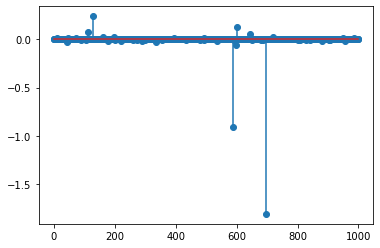

iteration 0
epoch iteration 0
epoch iteration 1
epoch iteration 2
epoch iteration 3
epoch iteration 4
epoch iteration 5
epoch iteration 6
epoch iteration 7
epoch iteration 8
epoch iteration 9
epoch iteration 10
epoch iteration 11
epoch iteration 12
epoch iteration 13
epoch iteration 14
epoch iteration 15
epoch iteration 16
epoch iteration 17
epoch iteration 18
epoch iteration 19
epoch iteration 20
epoch iteration 21
epoch iteration 22
epoch iteration 23
epoch iteration 24
epoch iteration 25
epoch iteration 26
epoch iteration 27
epoch iteration 28
epoch iteration 29
epoch iteration 30
epoch iteration 31
epoch iteration 32
epoch iteration 33
epoch iteration 34
epoch iteration 35
epoch iteration 36
epoch iteration 37
epoch iteration 38
epoch iteration 39
epoch iteration 40
epoch iteration 41
epoch iteration 42
epoch iteration 43
epoch iteration 44
epoch iteration 45
epoch iteration 46
epoch iteration 47
epoch iteration 48
epoch iteration 49
iteration 1
epoch iteration 0
epoch iteration 1


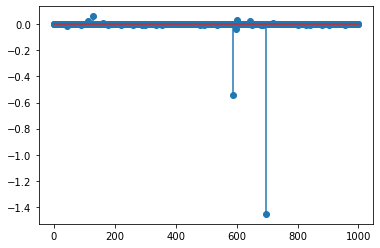

Text(0.5, 1.0, 'Solution')

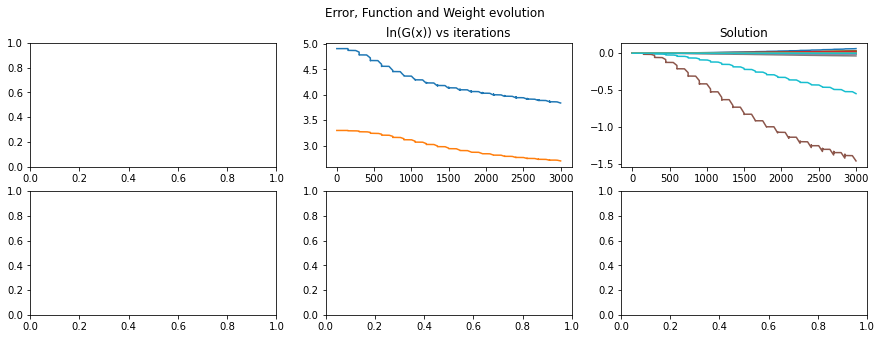

In [42]:
#Do SVRH-II
niter = 20
niteru = 100
epoch_sz = 50
xtemp3 = np.zeros((samples,(niteru+epoch_sz)*niter))
#epoch_sz = 2*features
funcvec_svr = np.zeros((lamsz,(niteru+epoch_sz)*niter))
#steparr = np.zeros((2,niter))
xtemp3 = np.zeros((samples,(niteru+epoch_sz)*niter))
#time_svr = np.zeros((lamsz,niter*epoch_sz))
mug = 1
#start = time.time()
stepv = 0.001
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    #u = np.zeros(samples)
    #v = np.zeros(samples)
    #stepu = 0.001
    #stepv = 0.001
    #start = time.time()
    for it in range(niter):
        print('iteration',it)
        Lg = np.linalg.norm(gnabUU(v,A,y,lam),2)
        stepu = 2 / (Lg + mug)
        for i in range(niteru):
            #stepu = 0.01/(1+i)**0.51
            #stepv = 0.01/(1+i)**0.51
            #stepu = 0.01/(1+i)**0.1
            #stepv = 0.01/(1+i)**0.1
            u = u - stepu * gnabU(u,v,A,y,lam)
            x = u*v
            xtemp3[:,it*(niteru + epoch_sz) + i] = x
            funcvec_svr[l,it*(niteru + epoch_sz) + i] = funcreg(A,x,y,lam)
            #funcvec_temp[i] = funcreg(A,u*v,y,lam)
            #xtemptemp[:,i] = u*v
    
        v0 = v
        #stepv = 0.01/(1+it)**0.51
        nabf_true = NablaF(u,v,A,y,lam)
        for j in range(epoch_sz):
            print('epoch iteration',j)
            rndindx = np.random.randint(features)
            v = v - stepv * (NablaF(u,v,A[rndindx,:],y[rndindx],lam) - NablaF(u,v0,A[rndindx,:],y[rndindx],lam) + nabF_avg)
            x = u * v
            xtemp3[:,(it+1)*niteru + it*epoch_sz + j] = x
            funcvec_svr[l,(it+1)*niteru + it*epoch_sz + j] = funcreg(A,x,y,lam)
            #time_svr[l,(it+1)*niteru + it*epoch_sz + j] = time.time() - start
        
        x = u * v
        #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
        #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
        #time_svr[l,i*epoch_sz+j] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_svr[l,-2])
    print("Subdifferential:", SubdifTest(A,u*v,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
#axs3[0,0].plot(time_svr[0,:],np.log(funcvec_svr[0,:].T));
#axs3[0,0].plot(time_svr[1,:],np.log(funcvec_svr[1,:].T));
#axs3[0,0].plot(time_svr[2,:],np.log(funcvec_svr[2,:].T));
#axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_svr.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

# HOAG

In [4]:
#Implement thresh/prox function for g(x) = ||1||_1
def prox(x,lam): 
    return np.sign(x) * np.maximum(np.abs(x)-lam*np.ones(np.size(x)),0)
def GradF(A,x,y):                   #Calculate gradient of ||Ax-y||_2^2
    return (((A.T @ A) @ x) - A.T @ y)
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    eps = 10**(-30)
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / (abs((st.T @ yt)) + eps)

In [5]:
#Use forward-backward to solve Step 1) of HOAG
def HoagSt1(A,y,features,samples,lam,niter):
    x = np.zeros(samples)
    #funcvec_fb = np.zeros((lamsz,niter))
    omg = .1/np.linalg.norm(A)
    #time_fb = np.zeros((lamsz,niter))
    #xtemp = np.zeros((samples,niter))
    #start = time.time()
    for i in range(niter):
        x = prox(x - (omg/lam)*(np.dot(np.matmul(A.T,A),x) - np.dot(A.T,y)),omg)
        #xtemp[:,i] = x
        #funcvec_fb[l,i] = funcreg(A,x,y,lam)
        #time_fb[l,i] = time.time() - start

    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    #print("Subdifferential:", SubdifTest(A,x,y,lam))

    #fig, axs = plt.subplots(1,3, figsize=(15,5))
    #fig.suptitle('Function and Weight evolution')
    #axs[0].plot(time_fb[0,:], np.log(funcvec_fb[0,:].T));
    #axs[0].set_title('ln(G(x)) vs time)')
    #axs[2].plot(xtemp.T);
    #axs[2].set_title('Solution')
    #axs[1].plot(np.log(funcvec_fb.T));
    #axs[1].set_title('ln(G(x)) vs Iterations)')
    return x

In [34]:
#Use BB-subgradient descent to solve Step 1) of HOAG
def HoagStSg1(A,y,features,samples,lam,niter):
    step = 0.001
    x = np.random.randn(samples)*0.0001
    x_old = x
    #xtemp3 = np.zeros((samples,niter))
    #funcvec_gdb = np.zeros(niter)
    #start = time.time()
    for i in range(niter):
        grad = GradF(A, x, y) + lam*np.sign(x)
        grad_old = GradF(A, x_old, y) + lam*np.sign(x_old)
        step = .1/np.linalg.norm(A)
        if(i > 0):
            step = BBstep(x,x_old,grad,grad_old)
    
        #steparr[i] = step
        x_old = x
        x = x - step*grad
        #xtemp3[:,i] = x
        #funcvec_gdb[i] = funcreg(A,x,y,lam)
        #time_gdb[l,i] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    #print("Subdifferential:", SubdifTest(A.T @ A,x,y,lam))
    #plt.stem(q)
    #plt.show()

    #fig, axs3 = plt.subplots(2,3, figsize=(15,5))
    #fig.suptitle('Error, Function and Weight evolution')
    #axs3[0,1].plot(np.log(funcvec_gdb.T));
    #axs3[0,1].set_title('ln(G(x)) vs iterations')
    #axs3[0,0].plot(time_gdb[0,:],np.log(funcvec_gdb[0,:].T));
    #axs3[0,0].set_title('ln(G(x)) vs time')
    #axs3[0,2].plot(xtemp3.T);
    #axs3[0,2].set_title('Solution')
    #axs3[1,0].plot(steparr.T);
    #axs3[1,0].set_title('Stepsize')
    return x

In [50]:
grad_test = A_test.T @ A_test @ x - A_test.T @ y_test
L = np.linalg.norm(grad_test,2)
ATA = A.T @ A

In [64]:
#Do GD-BB for STEP 2 of HOAG
def HoagSt2(ATA,grad_test,niter):
    step = 0.001
    funcvec_gdb = np.zeros(niter)
    #steparr = np.zeros(niter)
    #uold = u
    #vold = v
    #time_gdb = np.zeros((lamsz,niter))
    samples = np.size(ATA,1)
    xtemp3 = np.zeros((samples,niter))
    q = np.random.randn(samples)*0.0001
    q_old = q
    #start = time.time()
    for i in range(niter):
        grad = GradF(ATA, q, grad_test)
        grad_old = GradF(ATA, q_old, grad_test)
        step = .1/np.linalg.norm(ATA)
        if(i > 0):
            step = BBstep(q,q_old,grad,grad_old)
    
        #steparr[i] = step
        q_old = q
        q = q - step*grad
        xtemp3[:,i] = q
        funcvec_gdb[i] = np.linalg.norm(ATA@q-grad_test,2)
        #time_gdb[l,i] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    #print("Subdifferential:", SubdifTest(A.T @ A,x,y,lam))
    #plt.stem(q)
    #plt.show()

    fig, axs3 = plt.subplots(2,3, figsize=(15,5))
    fig.suptitle('Error, Function and Weight evolution')
    axs3[0,1].plot(np.log(funcvec_gdb.T));
    axs3[0,1].set_title('ln(G(x)) vs iterations')
    #axs3[0,0].plot(time_gdb[0,:],np.log(funcvec_gdb[0,:].T));
    #axs3[0,0].set_title('ln(G(x)) vs time')
    axs3[0,2].plot(xtemp3.T);
    #axs3[0,2].set_title('Solution')
    #axs3[1,0].plot(steparr.T);
    #axs3[1,0].set_title('Stepsize')
    return q

In [49]:
#Step 3 of HOAG

p = -np.sign(x) * q

iteration 0
Lambda =  0.10365694473594203
iteration 1
Lambda =  0.11442160358442134
iteration 2
Lambda =  0.11368709800312497
iteration 3
Lambda =  0.1165667474186944
iteration 4
Lambda =  0.11016434332421143
iteration 5
Lambda =  0.1218322853470622
iteration 6
Lambda =  0.14046109615238456
iteration 7
Lambda =  0.17060920213812808
iteration 8
Lambda =  0.1764326060653973
iteration 9
Lambda =  0.1785494772418659
iteration 10
Lambda =  0.17444216381504163
iteration 11
Lambda =  0.18479704904140248
iteration 12
Lambda =  0.19445040954518167
iteration 13
Lambda =  0.19103373719134978


KeyboardInterrupt: 

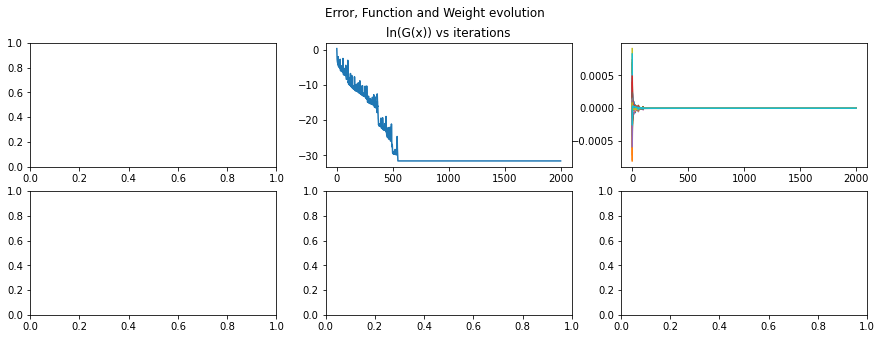

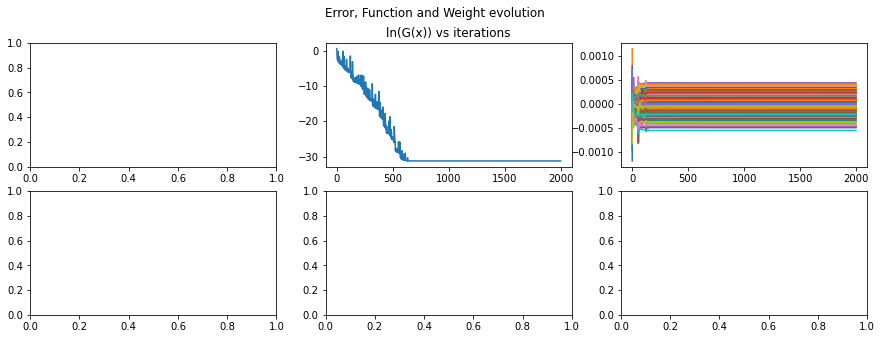

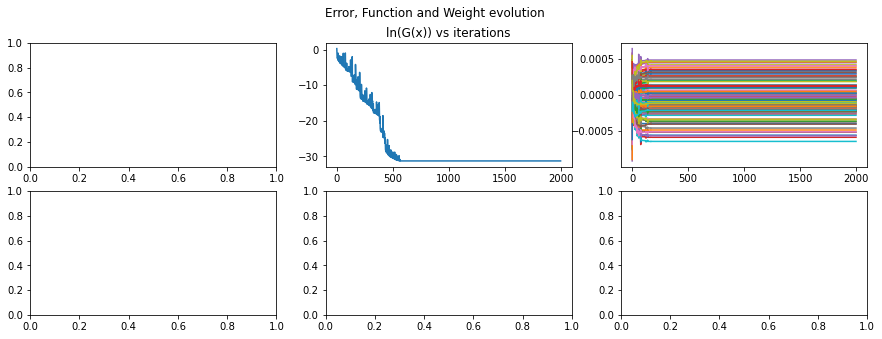

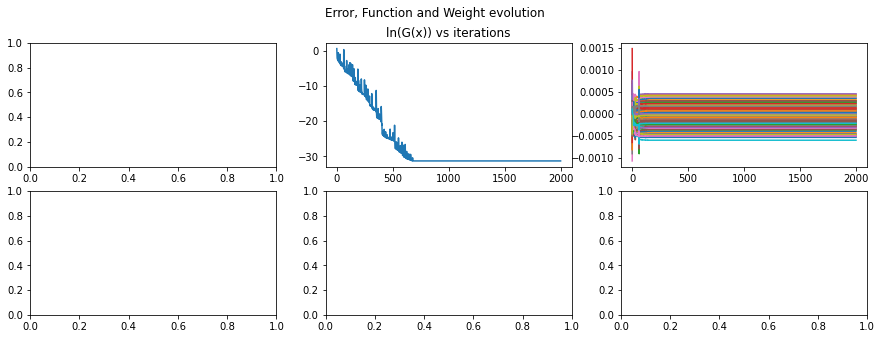

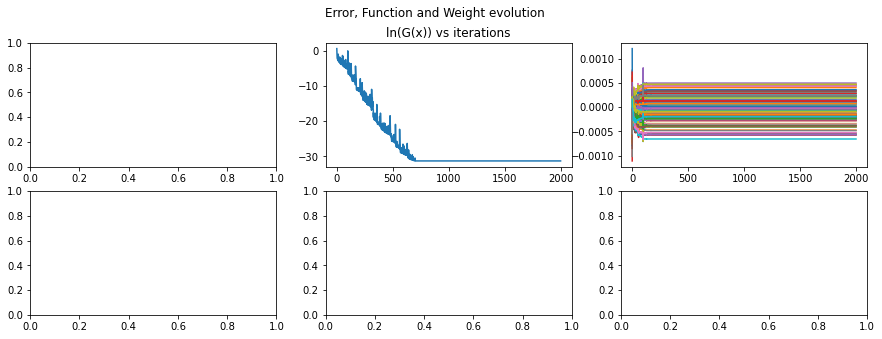

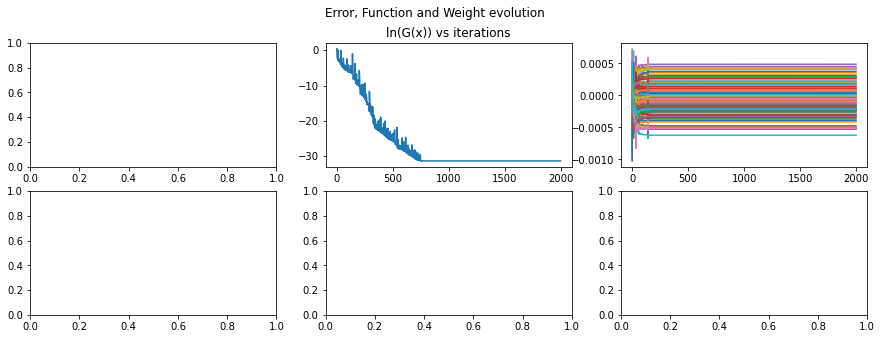

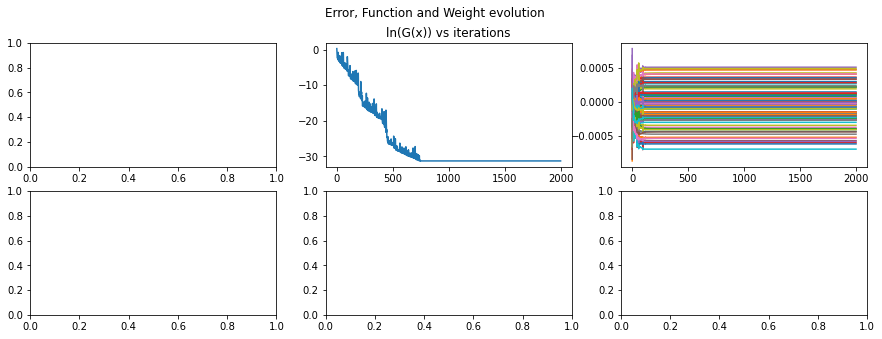

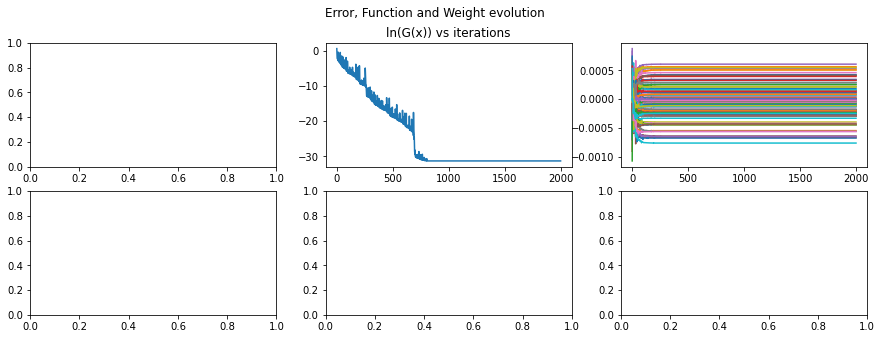

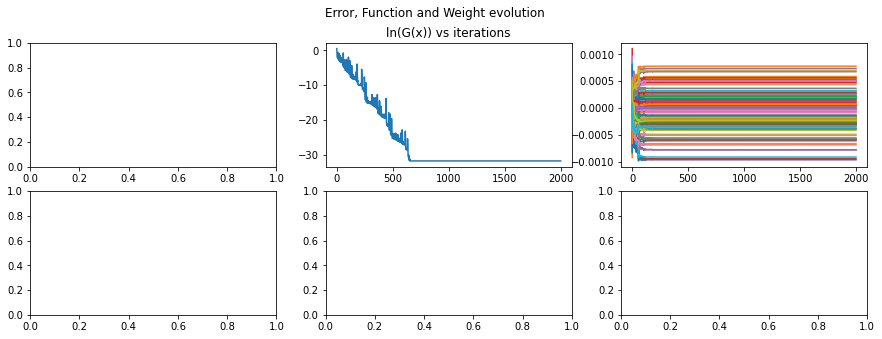

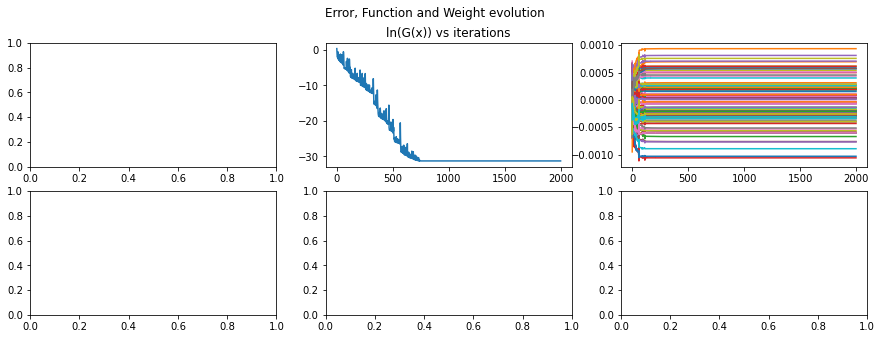

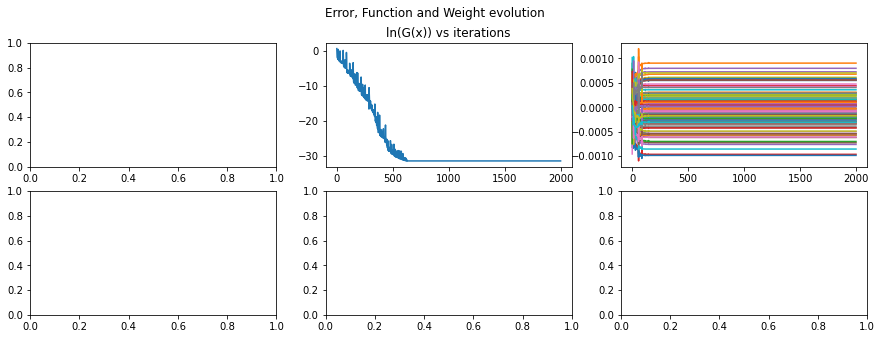

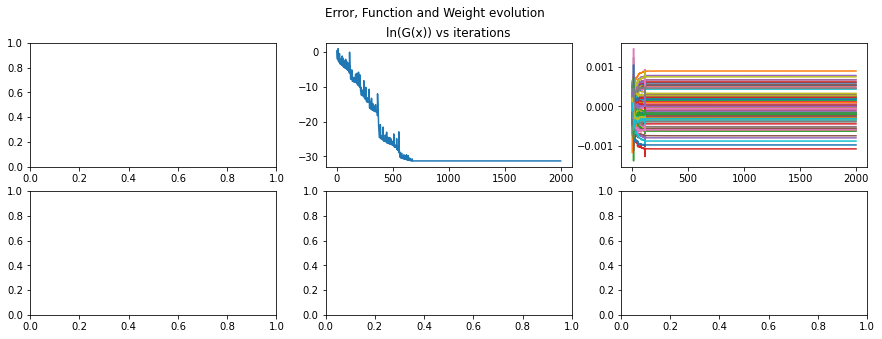

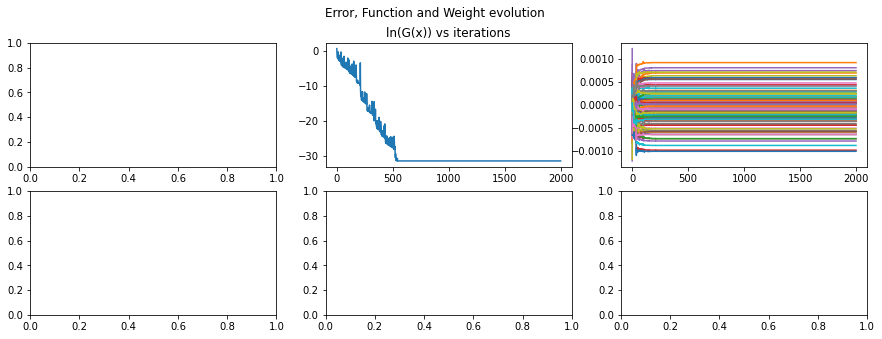

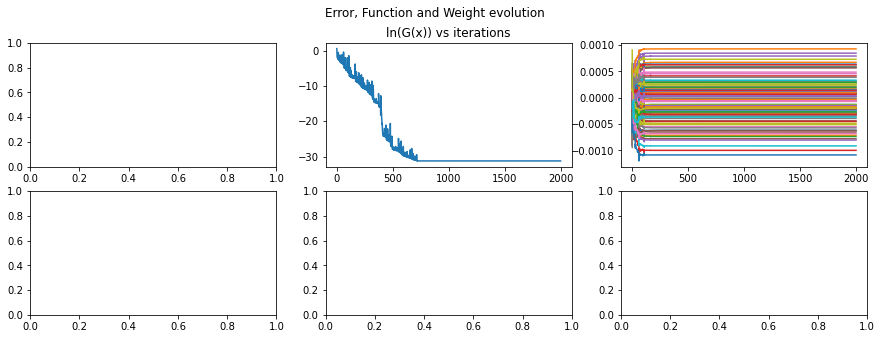

In [68]:
#Run the HOAG algorithm to find optimal lamda for testing set A_test
#Obtain exact solutions
#lamda = np.max(np.abs(A.T@y))/50
lamda = 0
liter = 1000
lamdas = np.zeros(liter)
niter = 1000
for i in range(liter):
    x = HoagStSg1(A,y,features,samples,lamda,niter)
    grad_test = A_test.T @ A_test @ x - A_test.T @ y_test
    L = np.linalg.norm(grad_test,2)
    ATA = A.T @ A
    q = HoagSt2(ATA,grad_test,2*niter)
    #Mistake below - derivative of sign(x) is not 0.
    p = -np.sign(x) @ q
    lamda = lamda - (1/L)*p
    lamdas[i] = lamda
    print('iteration', i)
    print('Lambda = ', lamda)
    
plt.plot(lamdas)

In [ ]:
#Use BB-subgradient descent to solve Step 1) of HOAG
def HoagStSg1_eps(A,y,features,samples,lam,niter,epsk,x_opt):
    step = 0.001
    x = np.random.randn(samples)*0.0001
    x_old = x
    #start = time.time()
    while (np.abs(x - x_opt) > epsk):
    #for i in range(niter):
        grad = GradF(A, x, y) + lam*np.sign(x)
        grad_old = GradF(A, x_old, y) + lam*np.sign(x_old)
        step = .1/np.linalg.norm(A)
        if(i > 0):
            step = BBstep(x,x_old,grad,grad_old)
    
        #steparr[i] = step
        x_old = x
        x = x - step*grad
        #xtemp3[:,i] = q
        #funcvec_gdb[l,i] = np.linalg.norm(ATA@q-grad_test,2)
        #time_gdb[l,i] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    #print("Subdifferential:", SubdifTest(A.T @ A,x,y,lam))
    #plt.stem(q)
    #plt.show()

    #fig, axs3 = plt.subplots(2,3, figsize=(15,5))
    #fig.suptitle('Error, Function and Weight evolution')
    #axs3[0,1].plot(np.log(funcvec_gdb.T));
    #axs3[0,1].set_title('ln(G(x)) vs iterations')
    #axs3[0,0].plot(time_gdb[0,:],np.log(funcvec_gdb[0,:].T));
    #axs3[0,0].set_title('ln(G(x)) vs time')
    #axs3[0,2].plot(xtemp3.T);
    #axs3[0,2].set_title('Solution')
    #axs3[1,0].plot(steparr.T);
    #axs3[1,0].set_title('Stepsize')
    return x

In [69]:
def GnabU(u,v,X,y,lam):
    return lam*u + v*((X.T @ X)@(v*u) - X.T @ y)
def GnabV(u,v,X,y,lam):
    return lam*v + u*((X.T @ X)@(v*u) - X.T @ y)
#Do gradient descent with step chosen using Barzilai-Borwein for Step 1 of HOAG algorithm on (u,v)-param.
def HOAG_uv_st1(A,y,features,samples,lam,niter):
    step = 0.001
    xtemp3 = np.zeros((samples,niter))
    funcvec_gdb = np.zeros(niter)
    #steparr = np.zeros((2,niter))
    #uold = u
    #vold = v
    #time_gdb = np.zeros((lamsz,niter))
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    #start = time.time()
    for i in range(niter):
        #rndindx = np.random.randint(0, samples, 1)[0]
        #ch_sample = A[:,rndindx].reshape(-1,1)
        gradu = GnabU(u,v,A,y,lam)
        gradv = GnabV(u,v,A,y,lam)
        #stepu = LineSearchU(u,v,ch_sample,y,lam)
        #stepv = LineSearchV(u,v,ch_sample,y,lam)
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        if(i > 0):
            stepu = BBstep(u,uold,GnabU(u,v,A,y,lam),GnabU(uold,vold,A,y,lam))
            stepv = BBstep(v,vold,GnabV(u,v,A,y,lam),GnabV(uold,vold,A,y,lam))
    
        #steparr[0,i] = stepu
        #steparr[1,i] = stepv
        uold = u
        vold = v
        u = u - stepu*gradu
        v = v - stepv*gradv
        x = u * v
        xtemp3[:,i] = x
        funcvec_gdb[i] = funcreg(A,x,y,lam)
        #time_gdb[l,i] = time.time() - start
    #end = time.time()
    #print('Time for', niter, 'iterations:', end - start, 'seconds')
    #print("Subdifferential:", SubdifTest(A,x,y,lam))
    #plt.stem(x)
    #plt.show()

    fig, axs3 = plt.subplots(2,3, figsize=(15,5))
    fig.suptitle('Error, Function and Weight evolution')
    axs3[0,1].plot(np.log(funcvec_gdb.T));
    axs3[0,1].set_title('ln(G(x)) vs iterations')
    #axs3[0,0].plot(time_gdb[0,:],np.log(funcvec_gdb[0,:].T));
    #axs3[0,0].plot(time_gdb[1,:],np.log(funcvec_gdb[1,:].T));
    #axs3[0,0].plot(time_gdb[2,:],np.log(funcvec_gdb[2,:].T));
    #axs3[0,0].set_title('ln(G(x)) vs time')
    axs3[0,2].plot(xtemp3.T);
    #axs3[0,2].set_title('Solution')
    #axs3[1,0].plot(steparr.T);
    #axs3[1,0].set_title('Stepsize')
    return u,v

iteration 0
Lambda =  -0.1333737594718687


<ipython-input-14-afbf1df8d6d8>:5: RuntimeWarning: overflow encountered in matmul
  fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
<ipython-input-69-aac96f8ef1fd>:4: RuntimeWarning: overflow encountered in multiply
  return lam*v + u*((X.T @ X)@(v*u) - X.T @ y)
<ipython-input-4-471046f27445>:10: RuntimeWarning: overflow encountered in matmul
  return (st.T @ st) / (abs((st.T @ yt)) + eps)
<ipython-input-4-471046f27445>:10: RuntimeWarning: invalid value encountered in matmul
  return (st.T @ st) / (abs((st.T @ yt)) + eps)
<ipython-input-69-aac96f8ef1fd>:48: RuntimeWarning: invalid value encountered in log
  axs3[0,1].plot(np.log(funcvec_gdb.T));


iteration 1
Lambda =  nan
iteration 2
Lambda =  nan


KeyboardInterrupt: 

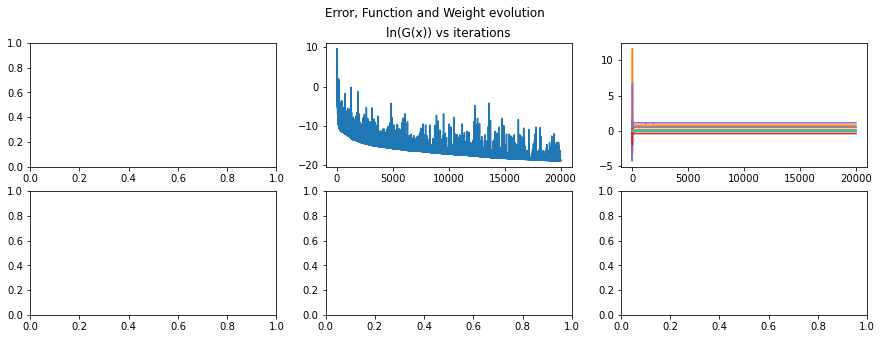

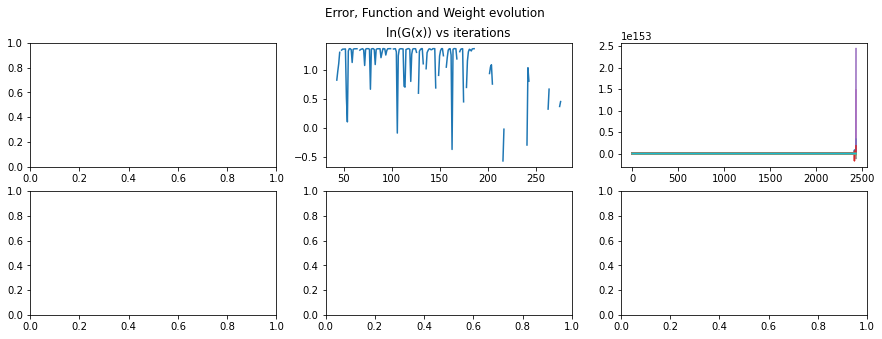

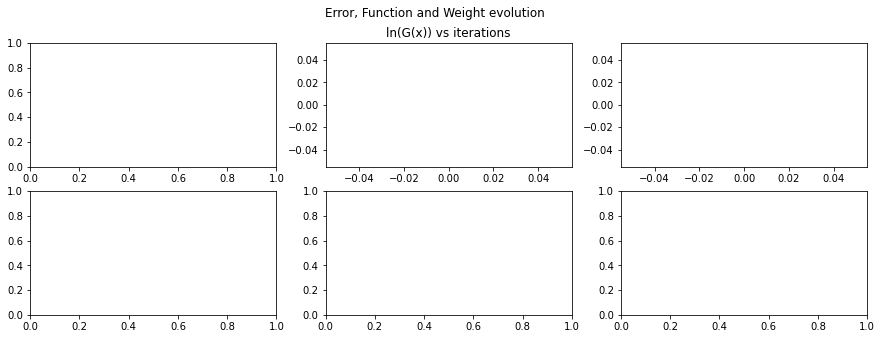

In [74]:
#Run the HOAG algorithm to find optimal lamda for testing set A_test
#Obtain exact solutions
#lamda = np.max(np.abs(A.T@y))/50
lamda = 0
liter = 1000
lamdas = np.zeros(liter)
niter = 20000
for i in range(liter):
    u,v = HOAG_uv_st1(A,y,features,samples,lamda,niter)
    B1B2 = np.block([np.eye(samples),np.eye(samples)])
    grad_test = A_test.T @ A_test @ x - A_test.T @ y_test
    L = np.linalg.norm(grad_test,2)
    DUU = gnabUU(v,A,y,lam)
    DVV = gnabUU(u,A,y,lam)
    DVU = gnabVU(u,v,A,y,lam)
    HessUV = np.block([[DUU,DVU],[DVU,DVV]])
    #q = HoagSt2(HessUV,B1B2.T @ grad_test,2*niter)
    q = np.linalg.inv(HessUV) @ B1B2.T @ grad_test
    uv = np.block([u,v])
    p = -uv @ (uv * q)
    lamda = lamda - (1/L)*p
    lamdas[i] = lamda
    print('iteration', i)
    print('Lambda = ', lamda)
    
plt.plot(lamdas)

In [48]:
np.size(grad_test0)

NameError: name 'grad_test0' is not defined

In [57]:
np.size(HessUV,0)

200